In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt
import pytz

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')

    UBNA_tz = pytz.timezone('US/Pacific')
    UTC_tz = pytz.timezone('UTC')

    file_dt_UTC = UTC_tz.localize(file_dt)
    file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
    file_title = f"{file_dt_PST.date()} {(file_dt_PST+pd.Timedelta(seconds=start)).strftime('%H:%M')} to {(file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration)).strftime('%H:%M')} PST"

    on = int(data_params['cur_dc_tag'].split('of')[0])
    total = int(data_params['cur_dc_tag'].split('of')[1])

    plt.figure(figsize=audio_features['figsize'])
    plt.rcParams.update({'font.size': 24})
    # plt.title(f"Number of calls recorded from {file_title}", fontsize=22)
    # plt.title(f"Number of calls", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmax=0, vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detected calls')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_dets.empty):
        num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), cycle_length_in_mins)
        plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle)

    windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(minutes=duration//60), freq=f'20S', inclusive='both')

    plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=np.linspace(0, duration, len(windows_PST)).astype(int))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (seconds)")
    plt.ylim(0, 96/125)
    # plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()

def plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')

    UBNA_tz = pytz.timezone('US/Pacific')
    UTC_tz = pytz.timezone('UTC')

    file_dt_UTC = UTC_tz.localize(file_dt)
    file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
    file_title = f"{file_dt_PST.date()} {(file_dt_PST+pd.Timedelta(seconds=start)).strftime('%H:%M')} to {(file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration)).strftime('%H:%M')} PST"

    on = int(data_params['cur_dc_tag'].split('of')[0])
    total = int(data_params['cur_dc_tag'].split('of')[1])

    plt.figure(figsize=audio_features['figsize'])
    plt.rcParams.update({'font.size': 24})
    # plt.title(f"Calls per minute from {file_title}", fontsize=22)
    # plt.title(f"Calls per minute", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmax=0, vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detected calls')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    time_on_in_mins = int(dc_tag.split('of')[0])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_dets.empty):
        num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), cycle_length_in_mins)
        callrate_per_cycle = actvt.get_metric_per_time_on(num_dets_per_cycle, duration/60)
        plot_recording_periods_with_callrate(ax, audio_features, data_params, (callrate_per_cycle).astype(int))

    windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(minutes=duration//60), freq=f'20S', inclusive='both')

    plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=np.linspace(0, duration, len(windows_PST)).astype(int))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (seconds)")
    plt.ylim(0, 96/125)
    # plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()

def plot_recording_periods_with_callrate(ax, audio_features, data_params, callrate_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/20
                plt.text(x=text_loc*fs/2, y=0.65*(96/125), s=f"{callrate_per_cycle[window_count]} calls/min", color='w', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/20)
                plt.text(x=text_loc*fs/2, y=0.65*(96/125), s=f"{callrate_per_cycle[window_count]} calls/min", color='w', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/20)
                plt.text(x=text_loc*fs/2, y=0.65*(96/125), s=f"{callrate_per_cycle[window_count]} calls/min", color='w', weight='bold')
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/20
                plt.text(x=text_loc*fs/2, y=0.65*(96/125), s=f"{num_dets_per_cycle[window_count]} calls", color='w', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/20)
                plt.text(x=text_loc*fs/2, y=0.65*(96/125), s=f"{num_dets_per_cycle[window_count]} calls", color='w', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/20)
                plt.text(x=text_loc*fs/2, y=0.65*(96/125), s=f"{num_dets_per_cycle[window_count]} calls", color='w', weight='bold')
                window_count+=1
            ax.add_patch(rect)

In [5]:
site_key = 'Carp'
freq_key = 'LF'

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)

In [6]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220722/Carp/20220720_080000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220

In [7]:
file = files_from_loc[32]
file

PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_080000.WAV')

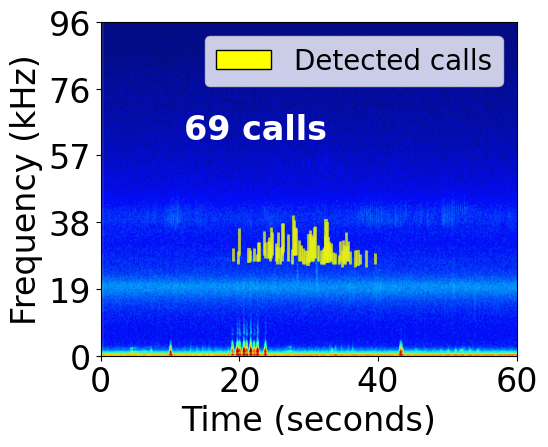

In [8]:
file_path = Path(file)
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 60
duration = 60
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 55 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['figsize'] = (6, 5)

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

data_params['cur_dc_tag'] = '5of5'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['recording_alpha'] = 0.3

file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, data_params)

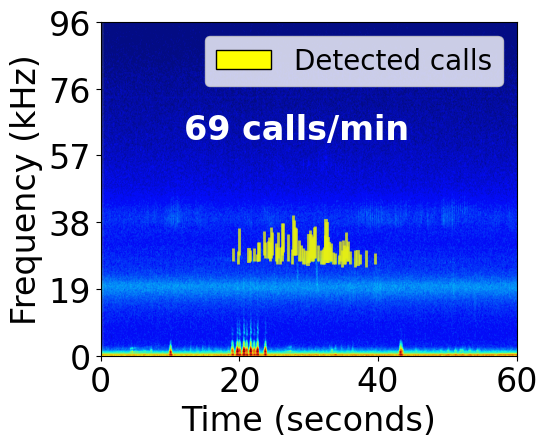

In [9]:
plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, data_params)